In [3]:
import os
os.environ['GCLOUD_PROJECT'] = 'XXX'
os.environ['BQ_DATASET'] = 'YYY'

In [8]:
from fal import FalDbt

faldbt = FalDbt(profiles_dir="./", project_dir="./")
print(faldbt.list_sources())
print(faldbt.list_models())

[['results', 'ticket_data_sentiment_analysis']]
{'model.fal_dbt_examples.boston': <RunStatus.Success: 'success'>, 'model.fal_dbt_examples.zendesk_ticket_metrics': <RunStatus.Success: 'success'>, 'model.fal_dbt_examples.stg_o3values': <RunStatus.Success: 'success'>, 'model.fal_dbt_examples.stg_zendesk_ticket_data': <RunStatus.Success: 'success'>, 'model.fal_dbt_examples.stg_counties': <RunStatus.Success: 'success'>}


In [45]:
sentiments = faldbt.source('results', 'ticket_data_sentiment_analysis')
sentiments = sentiments.drop_duplicates('id')
sentiments

,id,label,score
0,11013,NEGATIVE,0.8679937124252319
6,6171,POSITIVE,0.9987179040908813
12,1595,POSITIVE,0.9567179083824158
18,11071,POSITIVE,0.9949386119842529
24,16988,POSITIVE,0.9998757839202881
30,14173,POSITIVE,0.9995272159576416
36,4721,NEGATIVE,0.9998005032539368
42,1404,NEGATIVE,0.9994755387306213
48,1966,NEGATIVE,0.9922933578491211
54,6605,NEGATIVE,0.9995110034942627


In [46]:
tickets = faldbt.ref('stg_zendesk_ticket_data')
tickets

,id,_fivetran_synced,allow_channelback,assignee_id,brand_id,created_at,description,due_at,external_id,forum_topic_id,...,via_channel,via_source_from_id,via_source_from_title,via_source_rel,via_source_to_address,via_source_to_name,merged_ticket_ids,via_source_from_address,followup_ids,via_followup_source_id
0,4721,2020-05-14 20:12:36,False,396371706773,360003529474,2020-04-20 14:31:46,Huge disappointment,None,None,None,...,email,None,None,None,example@email.com,Support,[],None,None,None
1,6605,2020-06-10 02:10:24,False,396315360434,360003529474,2020-05-26 22:29:50,Full display not working in all application.,None,None,None,...,email,None,None,None,example@email.com,Support,[],None,None,None
2,1966,2020-03-25 20:32:24,False,396315360434,360003529474,2020-02-27 06:05:08,She doesn’t always listen,None,None,None,...,email,None,None,None,example@email.com,Support,[1967],None,None,None
3,14173,2020-11-11 20:08:45,False,396371699653,360003529474,2020-10-28 12:03:02,"I sent it to my 85 year old Dad, and he talks ...",None,None,None,...,email,None,None,None,example@email.com,Support,[],None,None,None
4,1404,2020-03-05 04:53:46,False,396371699653,360003529474,2020-02-13 21:43:58,Some major design flaws,None,None,None,...,email,None,None,None,example@email.com,Support,None,None,None,None
5,6171,2020-06-01 02:11:40,False,396334400494,360003529474,2020-05-17 17:50:31,nice hotel expensive parking got good deal sta...,None,None,None,...,email,None,None,None,example@email.com,Support,[],None,None,None
6,16988,2021-01-13 20:09:16,False,418284131934,360003529474,2020-12-22 00:19:23,Love it! I’ve listened to songs I haven’t hear...,None,None,None,...,email,None,None,None,example@email.com,Support,[],None,[],None
7,1595,2020-03-20 02:32:49,False,None,360003529474,2020-02-19 01:54:52,I think this is the 5th one I've purchased. I'...,None,None,None,...,web,None,None,None,example@email.com,None,[],None,None,None
8,11071,2020-10-02 14:08:33,False,None,360003529474,2020-08-28 18:06:36,"I love it, wife hates it.",None,None,None,...,email,None,None,None,X,Support,[],None,None,None
9,11013,2020-10-02 20:08:20,False,402851697393,360003529474,2020-08-27 23:09:52,I was a little nervous when I received my new ...,None,None,None,...,email,None,None,None,X,Support,[],None,None,None


In [60]:
import pandas as pd

def calc_weighted_label(row):
  val = 1 if row['label'] == 'POSITIVE' else -1
  return val * row['score']

joined = sentiments.merge(tickets, on='id')
joined['weighted_label'] = joined.apply(calc_weighted_label, axis=1).astype(float)
joined

,id,label,score,_fivetran_synced,allow_channelback,assignee_id,brand_id,created_at,description,due_at,...,via_source_from_id,via_source_from_title,via_source_rel,via_source_to_address,via_source_to_name,merged_ticket_ids,via_source_from_address,followup_ids,via_followup_source_id,weighted_label
0,11013,NEGATIVE,0.8679937124252319,2020-10-02 20:08:20,False,402851697393,360003529474,2020-08-27 23:09:52,I was a little nervous when I received my new ...,None,...,None,None,None,X,Support,[],None,None,None,-0.867994
1,6171,POSITIVE,0.9987179040908813,2020-06-01 02:11:40,False,396334400494,360003529474,2020-05-17 17:50:31,nice hotel expensive parking got good deal sta...,None,...,None,None,None,example@email.com,Support,[],None,None,None,0.998718
2,1595,POSITIVE,0.9567179083824158,2020-03-20 02:32:49,False,None,360003529474,2020-02-19 01:54:52,I think this is the 5th one I've purchased. I'...,None,...,None,None,None,example@email.com,None,[],None,None,None,0.956718
3,11071,POSITIVE,0.9949386119842529,2020-10-02 14:08:33,False,None,360003529474,2020-08-28 18:06:36,"I love it, wife hates it.",None,...,None,None,None,X,Support,[],None,None,None,0.994939
4,16988,POSITIVE,0.9998757839202881,2021-01-13 20:09:16,False,418284131934,360003529474,2020-12-22 00:19:23,Love it! I’ve listened to songs I haven’t hear...,None,...,None,None,None,example@email.com,Support,[],None,[],None,0.999876
5,14173,POSITIVE,0.9995272159576416,2020-11-11 20:08:45,False,396371699653,360003529474,2020-10-28 12:03:02,"I sent it to my 85 year old Dad, and he talks ...",None,...,None,None,None,example@email.com,Support,[],None,None,None,0.999527
6,4721,NEGATIVE,0.9998005032539368,2020-05-14 20:12:36,False,396371706773,360003529474,2020-04-20 14:31:46,Huge disappointment,None,...,None,None,None,example@email.com,Support,[],None,None,None,-0.999801
7,1404,NEGATIVE,0.9994755387306213,2020-03-05 04:53:46,False,396371699653,360003529474,2020-02-13 21:43:58,Some major design flaws,None,...,None,None,None,example@email.com,Support,None,None,None,None,-0.999476
8,1966,NEGATIVE,0.9922933578491211,2020-03-25 20:32:24,False,396315360434,360003529474,2020-02-27 06:05:08,She doesn’t always listen,None,...,None,None,None,example@email.com,Support,[1967],None,None,None,-0.992293
9,6605,NEGATIVE,0.9995110034942627,2020-06-10 02:10:24,False,396315360434,360003529474,2020-05-26 22:29:50,Full display not working in all application.,None,...,None,None,None,example@email.com,Support,[],None,None,None,-0.999511


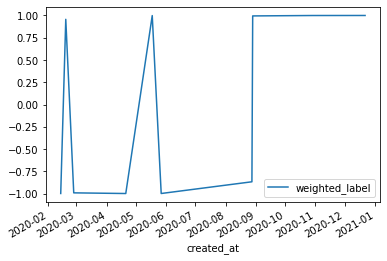

In [61]:
from matplotlib import pyplot as plt


joined.plot(y=['weighted_label'], x='created_at')
plt.show()
